In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import skyfield
import skyfield.api

import datetime

In [2]:
ea4gpz = skyfield.api.Topos(latitude = 40.595865, longitude = -3.699069, elevation_m = 800)
ts = skyfield.api.load.timescale(builtin=True)
tle1='1 45857U 20042B   20193.85379087  .00000513  00000-0  81606-4 0  9993'
tle2='2 45857  98.0133 266.8074 0010022 223.4288 136.6116 14.76202005  1284'
by02 = skyfield.api.EarthSatellite(tle1, tle2, 'BY02', ts)
print(by02)

EarthSatellite 'BY02' number=45857 epoch=2020-07-11T20:29:28Z


Text(0.5, 1.0, 'Power in 10kHz at 436.200MHz +/- Doppler')

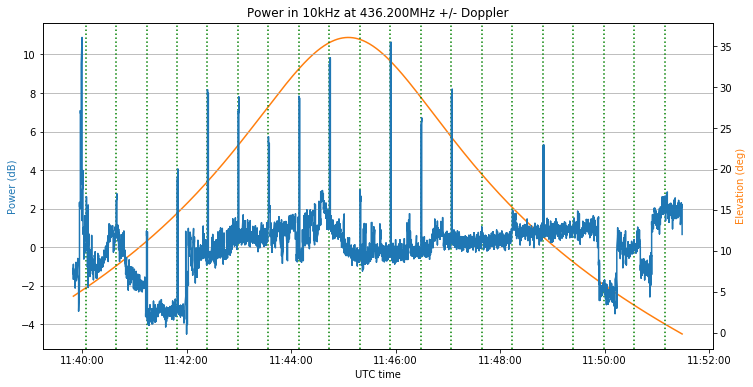

In [3]:
pwr = np.fromfile('by02_data/by02_pwr.f32', dtype = 'float32')
recstart = np.datetime64('2020-07-12T11:39:50')
pwr_T = 0.1
t_pwr = recstart + np.arange(pwr.size) * pwr_T * np.timedelta64(1,'s')
dt = [datetime.datetime.fromtimestamp(t, skyfield.api.utc)
      for t in (t_pwr - np.datetime64('1970-01-01'))/np.timedelta64(1,'s')]
t_pwr_skyfield = ts.utc(dt)

elevation = (by02-ea4gpz).at(t_pwr_skyfield).altaz()[0].degrees

packet_pos = np.arange(14, 700, 35)

plt.figure(figsize = (12,6), facecolor = 'w')
for s in packet_pos:
    plt.axvline(x = recstart + s * np.timedelta64(1, 's'), linestyle = ':', color = 'green')
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
ax2.plot()
ax2.plot(t_pwr, elevation, color = 'C1')
ax1.plot(t_pwr, 10 * np.log10(pwr) - 13, color = 'C0')
ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval = 2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.grid(axis = 'y')

ax1.set_ylabel('Power (dB)', color = 'C0')
ax2.set_ylabel('Elevation (deg)', color = 'C1')
ax1.set_xlabel('UTC time')

plt.title('Power in 10kHz at 436.200MHz +/- Doppler')

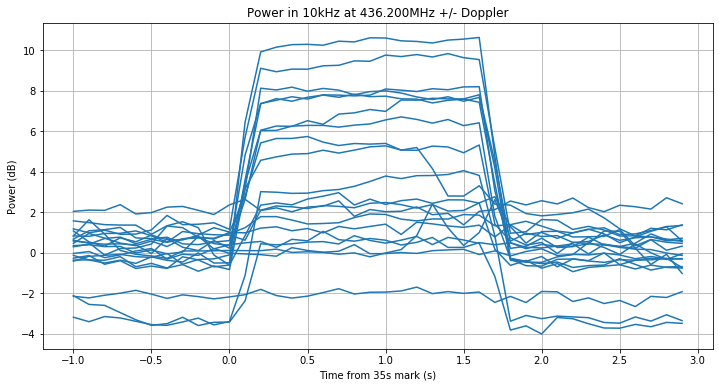

In [4]:
plt.figure(figsize = (12,6), facecolor = 'w')
for s in packet_pos:
    start = s - 1
    end = s + 3
    sel = slice(int(start/pwr_T), int(end/pwr_T))
    t = np.arange(pwr[sel].size)*pwr_T - 1
    plt.plot(t, 10 * np.log10(pwr[sel]) - 13, color = 'C0')
plt.ylabel('Power (dB)')
plt.xlabel('Time from 35s mark (s)')
plt.title('Power in 10kHz at 436.200MHz +/- Doppler')
plt.grid();

In [5]:
# run 
# gr_satellites BY02 --rawfile /tmp/by02_sel.c64 --samp_rate 48e3 --iq --syncword_threshold 2 --dump_path /tmp/dump/  --clk_bw 0.1  --clk_limit 0.005 --fll_bw 10 --costas_bw 75  | grep "frame_count" | awk '{print $3;}' > /tmp/frame_count

In [6]:
frame_count = np.fromfile('by02_data/frame_count', sep = '\n').reshape((-1,2))

In [7]:
# Throw away frames where master_frame_count - virtual_channel_frame_count != -1
frame_count_sel = frame_count[:,0] - frame_count[:,1] == -1
frame_count_good = frame_count[frame_count_sel]

(0, 255)

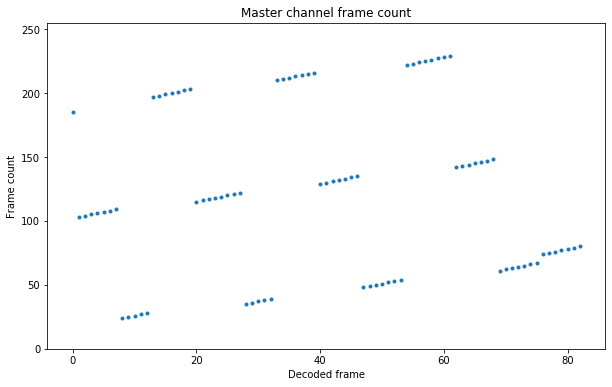

In [8]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(frame_count_good[:,0], '.')
plt.title('Master channel frame count')
plt.xlabel('Decoded frame')
plt.ylabel('Frame count')
plt.ylim((0,255))

In [9]:
np.diff(frame_count_good[:,0].astype('uint8'))

array([174,   1,   1,   1,   1,   1,   1, 171,   1,   1,   1,   1, 169,
         1,   1,   1,   1,   1,   1, 168,   1,   1,   1,   1,   1,   1,
         1, 169,   1,   1,   1,   1, 171,   1,   1,   1,   1,   1,   1,
       169,   1,   1,   1,   1,   1,   1, 169,   1,   1,   1,   1,   1,
         1, 168,   1,   1,   1,   1,   1,   1,   1, 169,   1,   1,   1,
         1,   1,   1, 169,   1,   1,   1,   1,   1,   1,   7,   1,   1,
         1,   1,   1,   1], dtype=uint8)

In [10]:
# run
# gr_satellites BY02 --rawfile /tmp/by02_sel.c64 --samp_rate 48e3 --iq --syncword_threshold 2 --dump_path /tmp/dump/  --clk_bw 0.1  --clk_limit 0.005 --fll_bw 10 --costas_bw 75  2>&1 >/dev/null | grep sample | awk {'print $9;'} > /tmp/tags

In [11]:
tags = np.fromfile('by02_data/tags', sep = '\n')

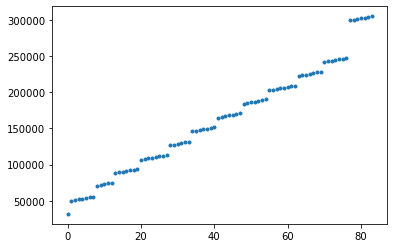

In [12]:
plt.plot(tags, '.')

(0, 255)

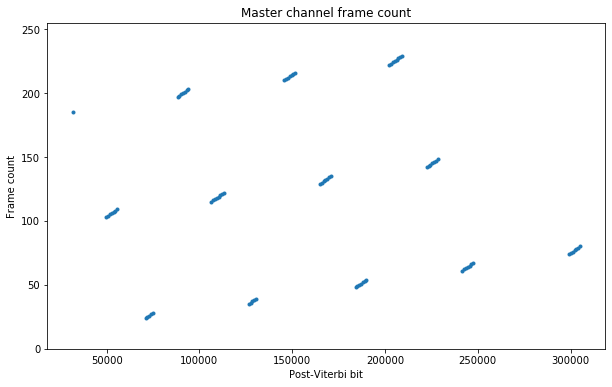

In [13]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(tags[frame_count_sel], frame_count_good[:,0], '.')
plt.title('Master channel frame count')
plt.xlabel('Post-Viterbi bit')
plt.ylabel('Frame count')
plt.ylim((0,255))

In [14]:
frameA = np.array([103, 197, 116, 35, 210, 129, 48, 223, 142, 61, 74])
frameB = frameA + 1

In [15]:
# Run
# gr_satellites BY02 --rawfile /tmp/by02_sel.c64 --samp_rate 48e3 --iq --syncword_threshold 2 --dump_path /tmp/dump/  --clk_bw 0.1  --clk_limit 0.005 --fll_bw 10 --costas_bw 75

In [16]:
x = np.fromfile('by02_data/costas_out.c64', dtype = 'complex64')

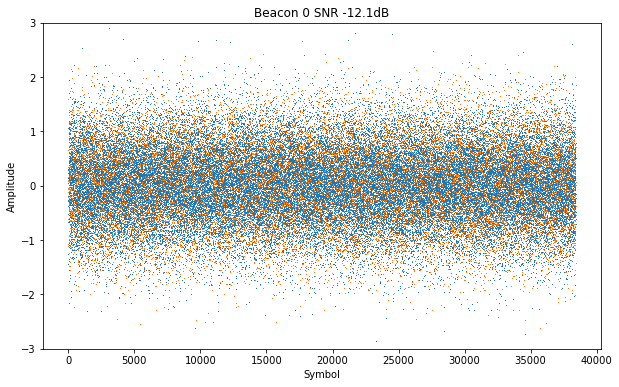

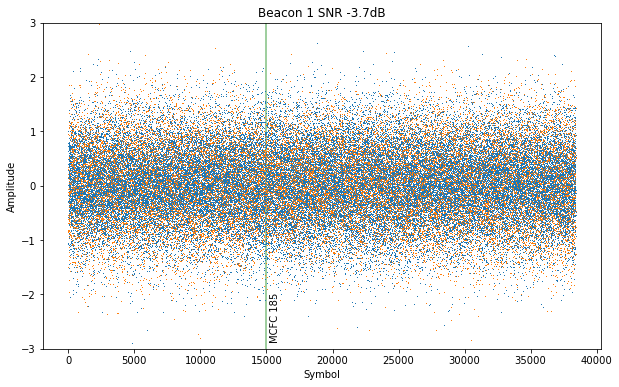

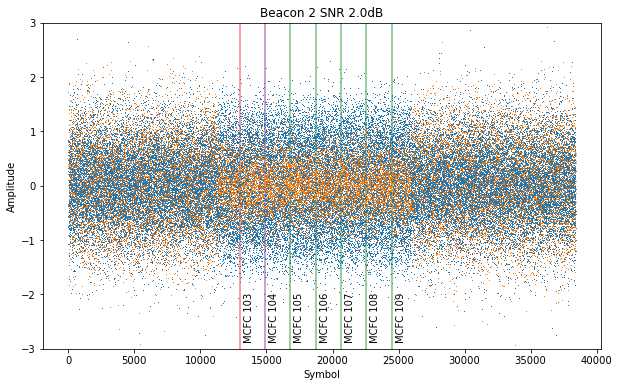

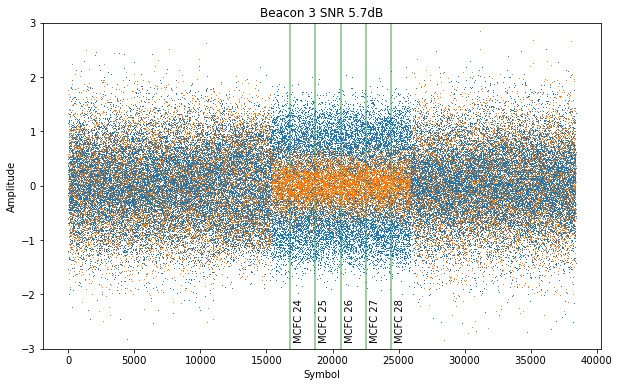

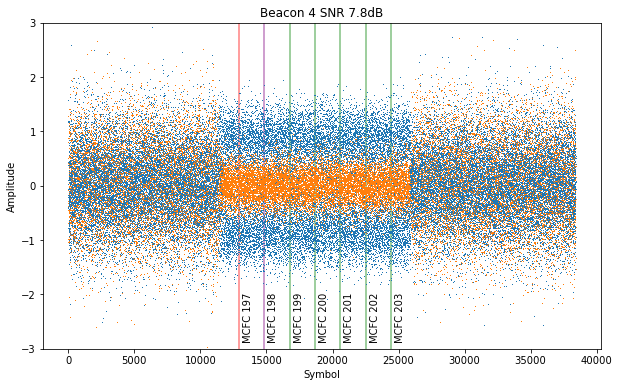

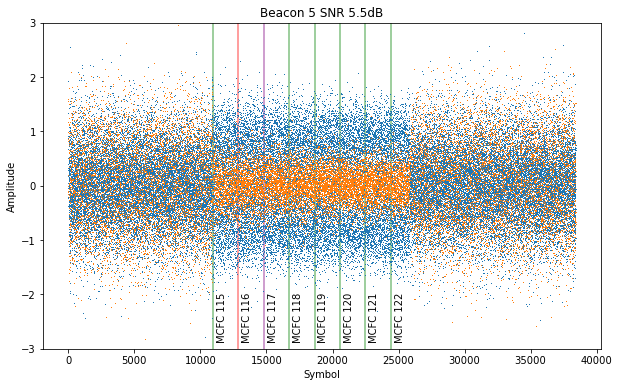

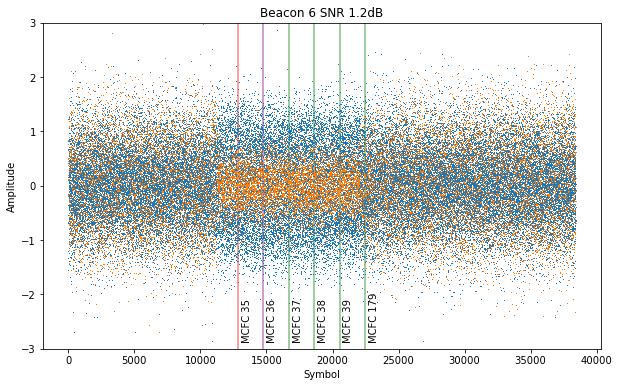

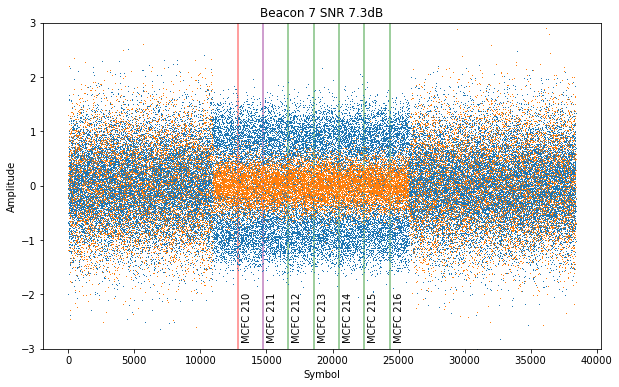

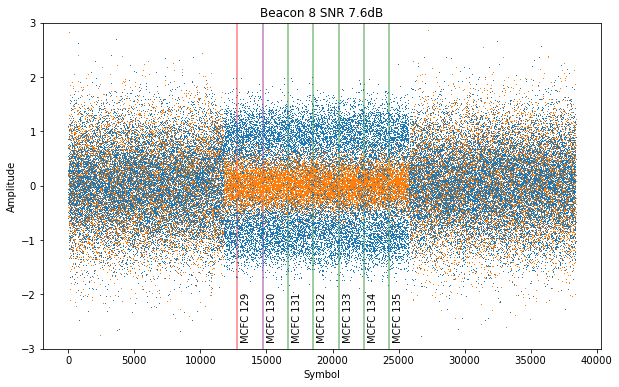

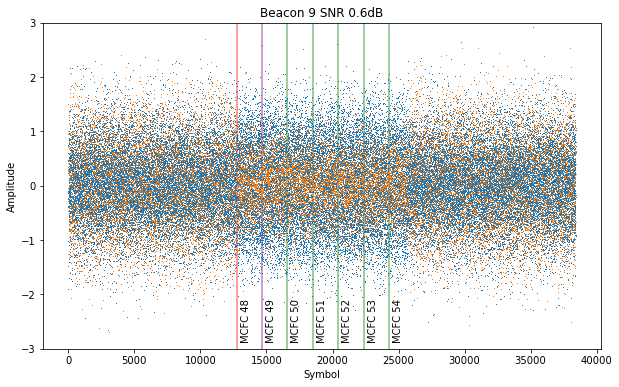

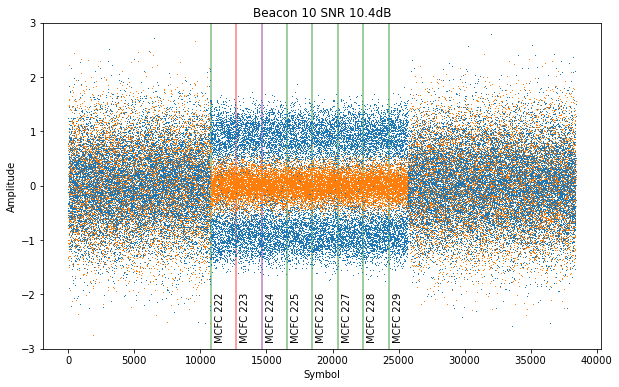

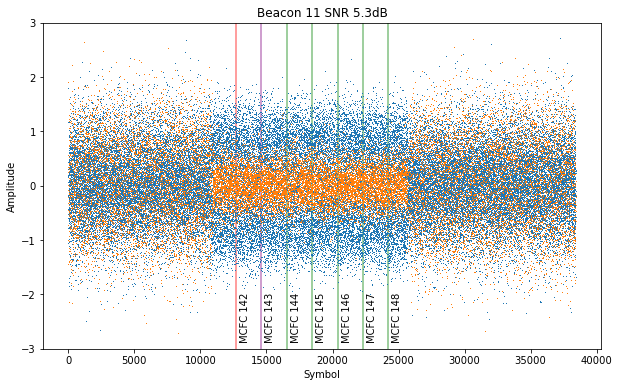

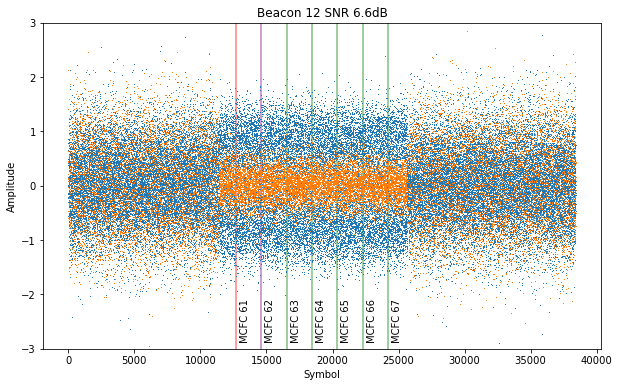

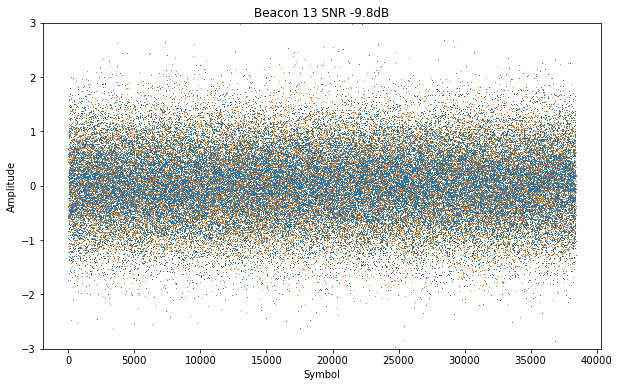

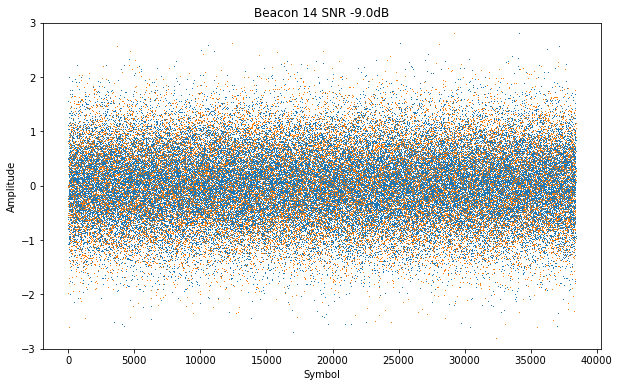

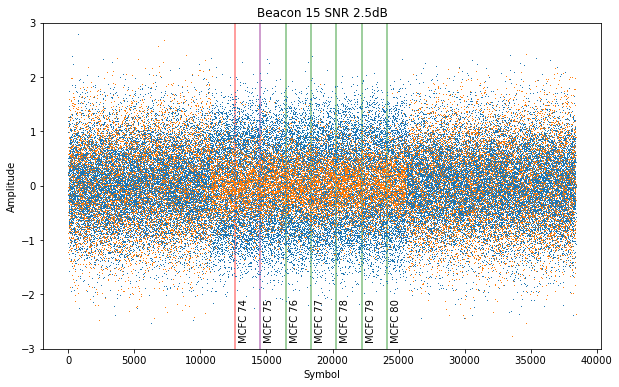

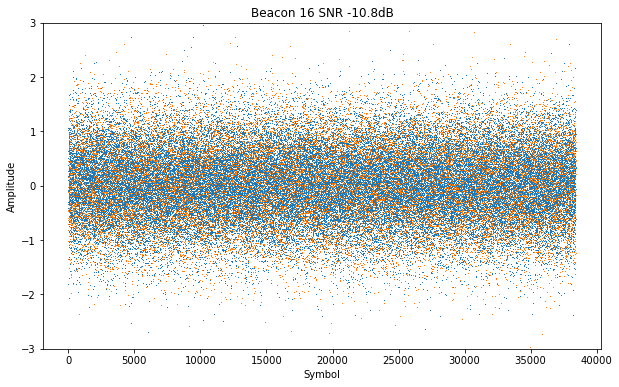

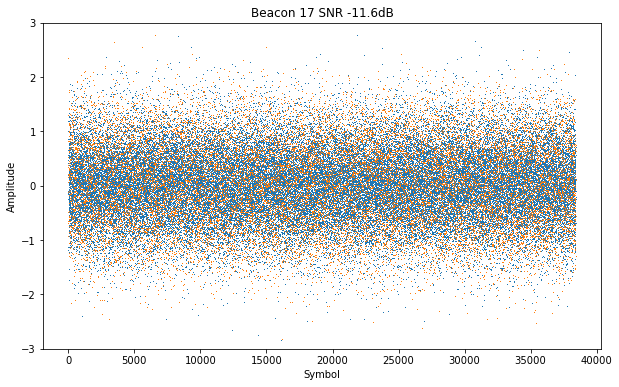

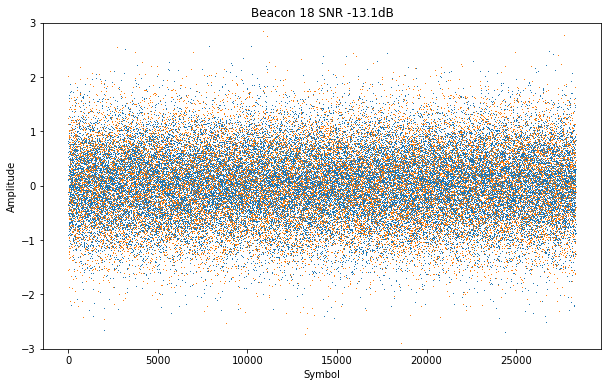

In [17]:
for j,a in enumerate(range(10000, x.size, 9600 * 4)):
    b = a + 9600 * 4
    plt.figure(figsize = (10, 6))
    tags_sel = (tags*2 >= a) & (tags*2 <= b)
    ts = 2*tags[(tags*2 >= a) & (tags*2 <= b)]
    for t,loc in zip(ts - a, np.where(tags_sel)[0]):
        mcfc = int(frame_count[loc,0])
        color = 'red' if mcfc in set(frameA) else 'purple' if mcfc in set(frameB) else 'green'
        plt.axvline(x = t, color = color, alpha = 0.5)
        plt.text(t + 300, -2.85, f'MCFC {mcfc}', rotation = 90)
    
    plt.plot(x[a:b].imag, ',', color = 'C1')
    plt.plot(x[a:b].real, ',', color = 'C0')

    
    start = packet_pos[j] + 2
    end = packet_pos[j] + 3
    sel = slice(int(start/pwr_T), int(end/pwr_T))
    n = np.average(pwr[sel])
    start = packet_pos[j] + 0.5
    end = packet_pos[j] + 1.5
    sel = slice(int(start/pwr_T), int(end/pwr_T))
    sn = np.average(pwr[sel])
    snr = 10*np.log10((sn - n)/n)
    plt.title(f'Beacon {j} SNR {snr:.1f}dB')
    plt.ylabel('Amplitude')
    plt.xlabel('Symbol')
    plt.ylim((-3,3))